In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

import krige_tools
import fields
import variogram as vgm
import cov_model

In [4]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

In [5]:
# Analysis variables
month = 7
timedelta = -1
n_bins = 50
fast_dist = True

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")

For each of the three methods, collect data from all available July, plot the scaled data and plot the variogram/covariogram with bin counts for each dataset

In [15]:
# Helper functions
def plot_fields(mf):
    da_xco2 = mf.field_1.ds.xco2
    da_sif = mf.field_2.ds.sif
    
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(100, 100)
    extents = [-125, -60, 5, 52]

    ax1 = fig.add_subplot(gs[:, 0:45], projection=ccrs.EqualEarth())
    ax2 = fig.add_subplot(gs[:, 50:95], projection=ccrs.EqualEarth())
    
    xr.plot.imshow(
            darray=da_xco2.T,
            transform=ccrs.PlateCarree(),
            ax=ax1,
            cmap="jet",
            vmin=-2,
            center=0,
            cbar_kwargs={"label": "scaled process residuals"},
        )
    ax1.coastlines()
    ax1.set_extent(extents)
    ax1.set_title(f"XCO$_2$: {pd.to_datetime(da_xco2.time.values).strftime('%Y-%m')}", 
                  fontsize=14)

    xr.plot.imshow(
            darray=da_sif.T,
            transform=ccrs.PlateCarree(),
            ax=ax2,
            cmap="jet",
            vmin=-2,
            center=0,
            cbar_kwargs={"label": "scaled process residuals"},
        )
    ax2.coastlines()
    ax2.set_extent(extents)
    ax2.set_title(f"SIF: {pd.to_datetime(da_sif.time.values).strftime('%Y-%m')}", 
                  fontsize=14)
    return fig
    
def param_labels(params, cross=False):
    p = np.round_(params, decimals=3)
    if cross:
        return f"nu: {p[0]}\nlen_scale: {p[1]}\nrho: {p[2]}"
    else:
        return f"sigma: {p[0]}\n nu: {p[1]}\n len_scale: {p[2]}\n nugget: {p[3]}"
    

def plot_semivariograms(vario_res, timestamp, method):
    fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
    ax[0, 1].axis("off")
    
    lags = vario_res["xco2"]["bin_center"].values
    bin_width = lags[2] - lags[1]

    for i, var in enumerate(var_names):
        df = vario_res[var]
        df.plot(x="bin_center", y="bin_mean", kind="scatter", color="white", ax=ax[i, i], label="Empirical semivariogram")
        for j, txt in enumerate(df["count"]):
            ax[i, i].annotate(np.int(txt), (df.bin_center.values[j], df.bin_mean.values[j]), xytext=(0, 0), textcoords="offset points", ha="center", fontsize=10)
        ax[i, i].set_title(var, fontsize=12)
        ax[i, i].set_ylabel("semivariance", fontsize=12)
        ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
        ax[i, i].legend(loc="upper left")

    df = vario_res[cross_name]
    df.plot(x="bin_center", y="bin_mean", kind="scatter", color="white", ax=ax[1, 0], label="Empirical cross-semivariogram")
    for j, txt in enumerate(df["count"]):
        ax[1, 0].annotate(np.int(txt), (df.bin_center.values[j], df.bin_mean.values[j]), xytext=(0, 0), textcoords="offset points", ha="center", fontsize=10)
    ax[1, 0].set_ylabel("semivariance", fontsize=12)
    ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

    ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=14)
    ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
    ax[1, 1].set_title("Semivariogram: SIF", fontsize=14)

    fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n"+
                f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14)
    fig.savefig(f"../plots/semivariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_method{method}.png", dpi=100);
    
    
def plot_covariograms(covario_res, timestamp, method):
    fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
    ax[0, 1].axis("off")
    
    lags = covario_res["xco2"]["bin_center"].values
    bin_width = lags[2] - lags[1]

    for i, var in enumerate(var_names):
        df = covario_res[var]
        df.plot(x="bin_center", y="bin_mean", kind="scatter", color="white", ax=ax[i, i], label="Empirical covariogram")
        for j, txt in enumerate(df["count"]):
            ax[i, i].annotate(np.int(txt), (df.bin_center.values[j], df.bin_mean.values[j]), xytext=(0, 0), textcoords="offset points", ha="center", fontsize=10)
        ax[i, i].set_title(var, fontsize=12)
        ax[i, i].set_ylabel("covariance", fontsize=12)
        ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
        ax[i, i].legend()

    df = covario_res[cross_name]
    df.plot(x="bin_center", y="bin_mean", kind="scatter", color="white", ax=ax[1, 0], label="Empirical cross-covariogram")
    for j, txt in enumerate(df["count"]):
        ax[1, 0].annotate(np.int(txt), (df.bin_center.values[j], df.bin_mean.values[j]), xytext=(0, 0), textcoords="offset points", ha="center", fontsize=10)
    ax[1, 0].legend(loc="upper left")
    ax[1, 0].set_ylabel("cross covariance", fontsize=12)
    ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

    ax[0, 0].set_title("Covariogram: XCO$_2$", fontsize=14)
    ax[1, 0].set_title(f"Cross-covariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
    ax[1, 1].set_title("Covariogram: SIF", fontsize=14)

    fig.suptitle("Covariograms and cross-covariogram for XCO$_2$ and SIF residuals\n"+
                f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14)
    fig.savefig(f"../plots/covariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_method{method}.png", dpi=100);

## Method 1

Data scaled by empirical (variogram) sill, local temporal trend and constant spatial mean removed

In [18]:
def method_1(timestamp):
    method = 1
    
    # Approximate the empirical sill
    mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, spatial_mean="constant", fast_dist=fast_dist)
    vario_res, _, _ = vgm.variogram_analysis(mf, [], [], n_bins=n_bins)

    # Rescale the data
    scales = [np.sqrt(np.max(vario_res["xco2"]["bin_mean"])), np.sqrt(np.max(vario_res["sif"]["bin_mean"]))]
    mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, spatial_mean="constant", scale_facts=scales, fast_dist=fast_dist)

    # Recompute variograms
    vario_res, covario_res, _ = vgm.variogram_analysis(mf, [], [], n_bins=n_bins)

    lags = vario_res["xco2"]["bin_center"].values
    bin_width = lags[2] - lags[1]
    
    # Plot variograms
    plot_semivariograms(vario_res, timestamp, method)
    plot_covariograms(covario_res, timestamp, method)
    
    # Plot maps
    fig = plot_fields(mf)
    fig.suptitle(
        "XCO$_2$ and SIF: 4x5-degree monthly averages\n"+
        "Data scaled by empirical (variogram) sill, local temporal trend and constant spatial mean removed", 
        size=14, y=1.05
    )
    fig.savefig(f"../plots/4x5degree_monthly_avg_residuals_method{method}_{timestamp}.png", dpi=200)

../src/variogram.py:82: UserWarning: WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation.
  f"WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation."
../src/variogram.py:82: UserWarning: WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation.
  f"WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation."
../src/variogram.py:82: UserWarning: WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation.
  f"WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation."
../src/variogram.py:82: UserWarning: WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation.
  f"WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation."
../src/variogram.py:82: UserWarning: WARNING: Fewer than 30 pairs used for at least one bin in covariogram calculation.
  f"WARNING: Fewer than 30 pairs used for at lea

[None, None, None, None, None, None]

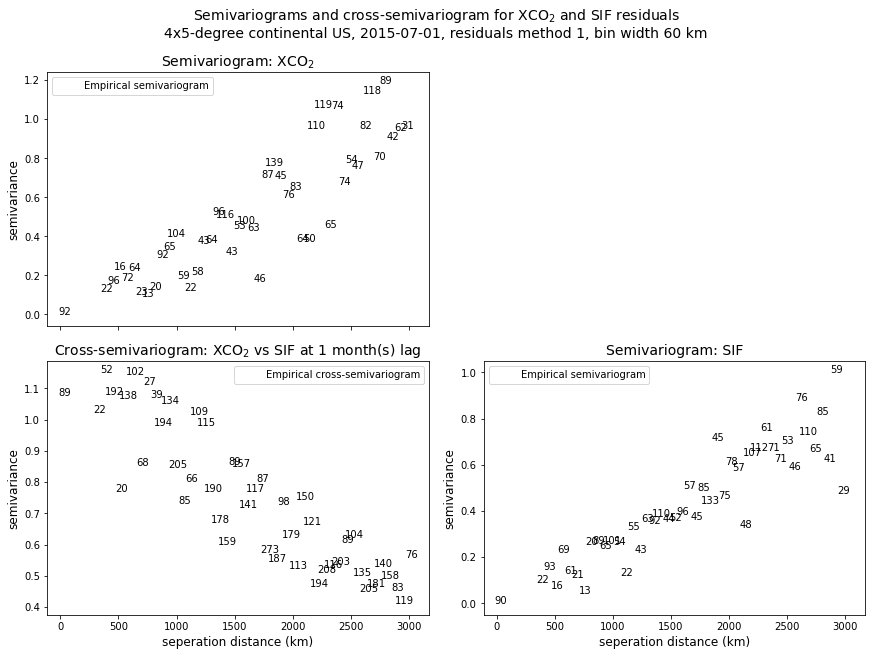

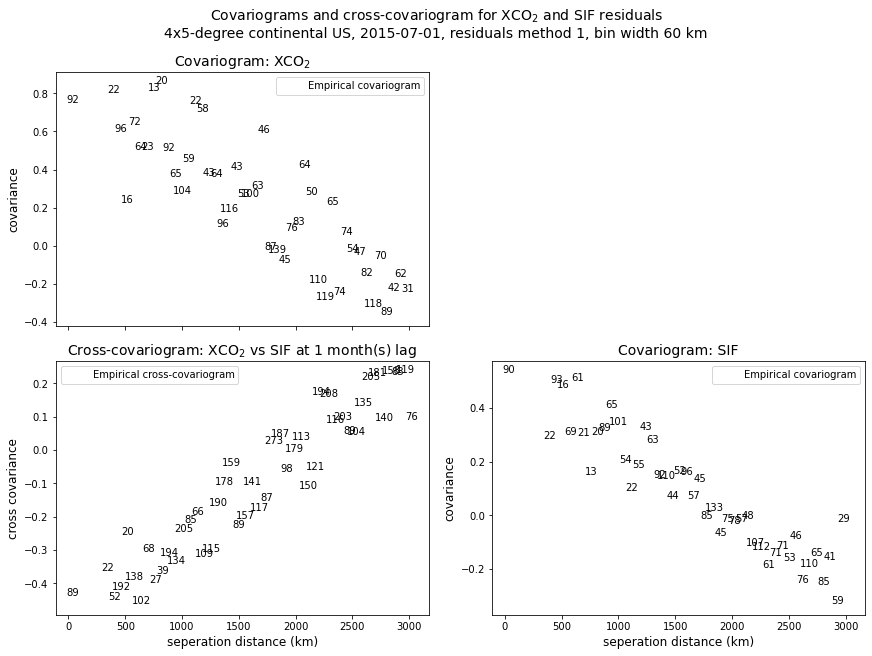

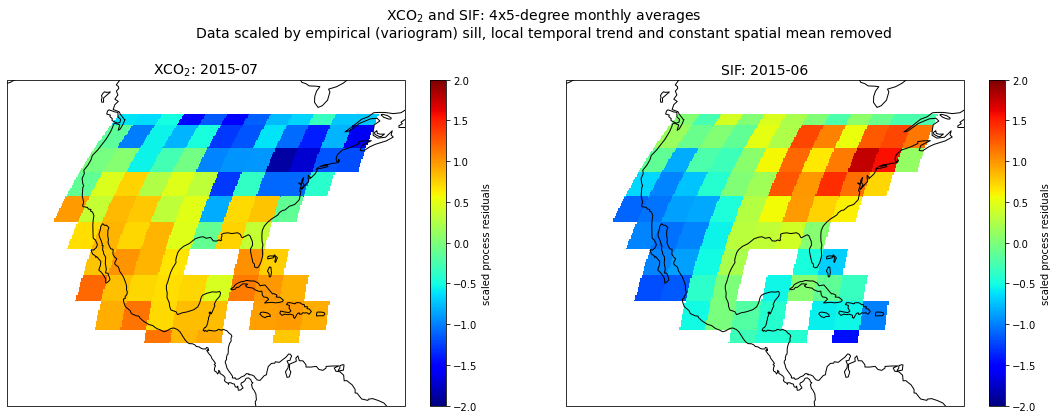

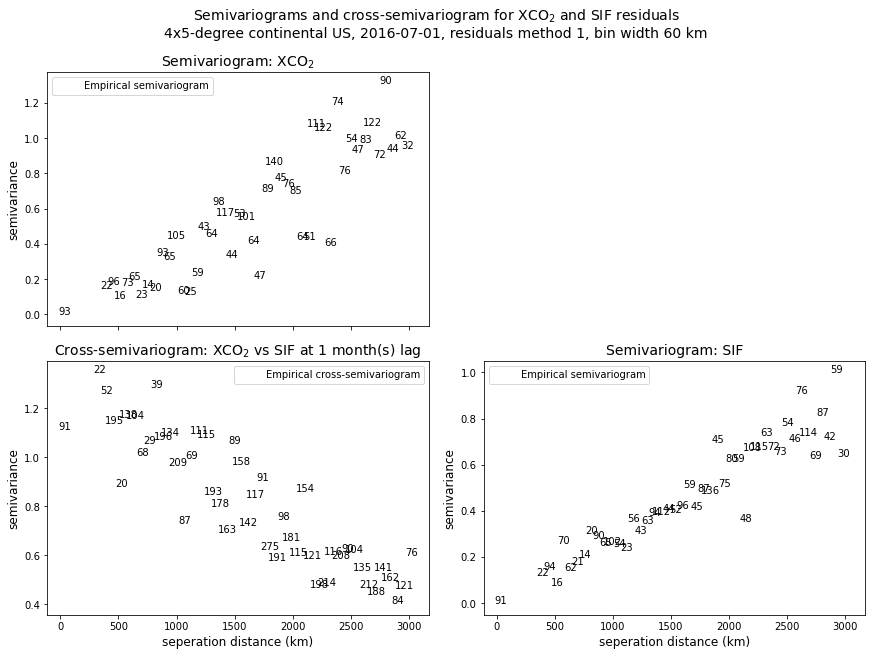

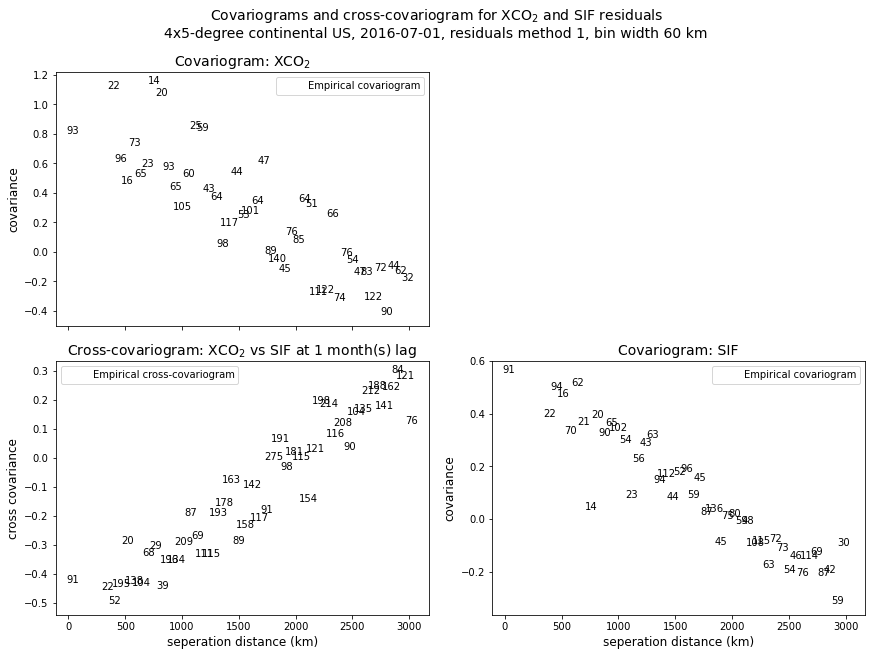

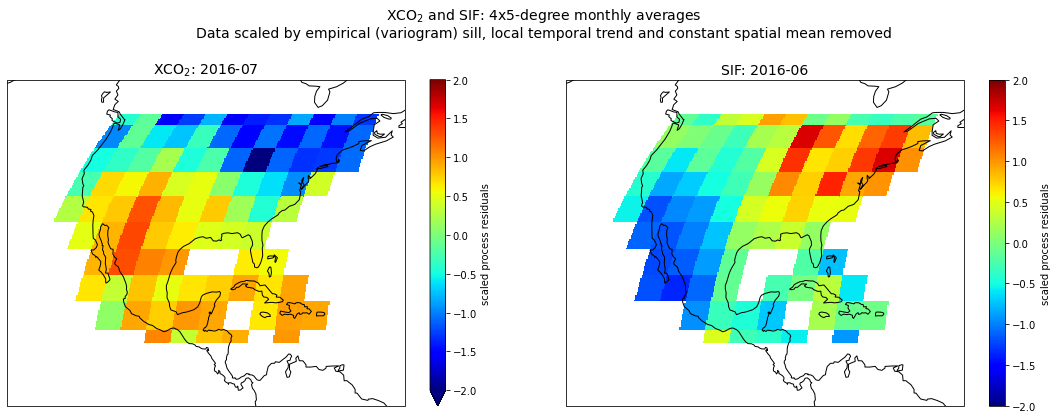

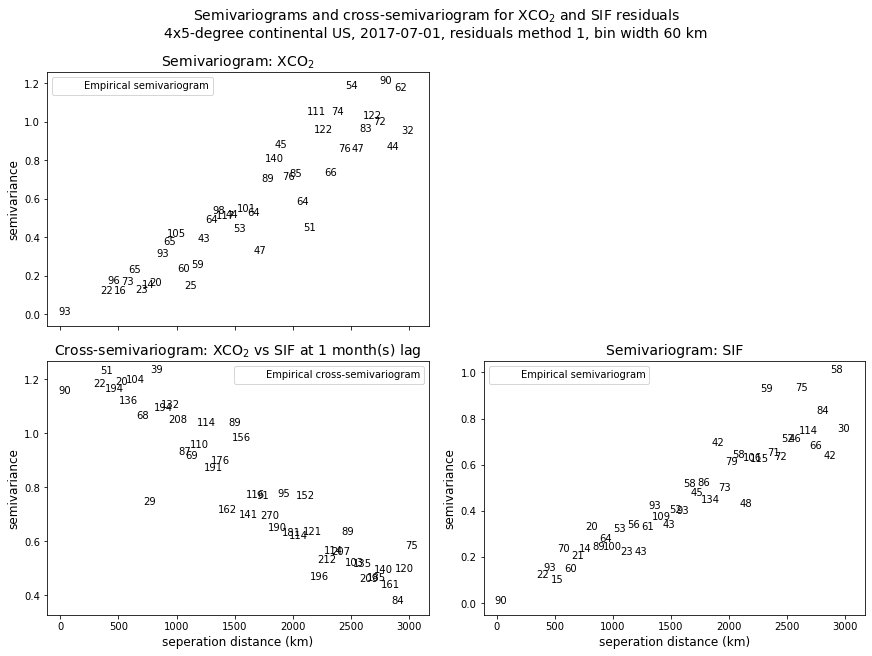

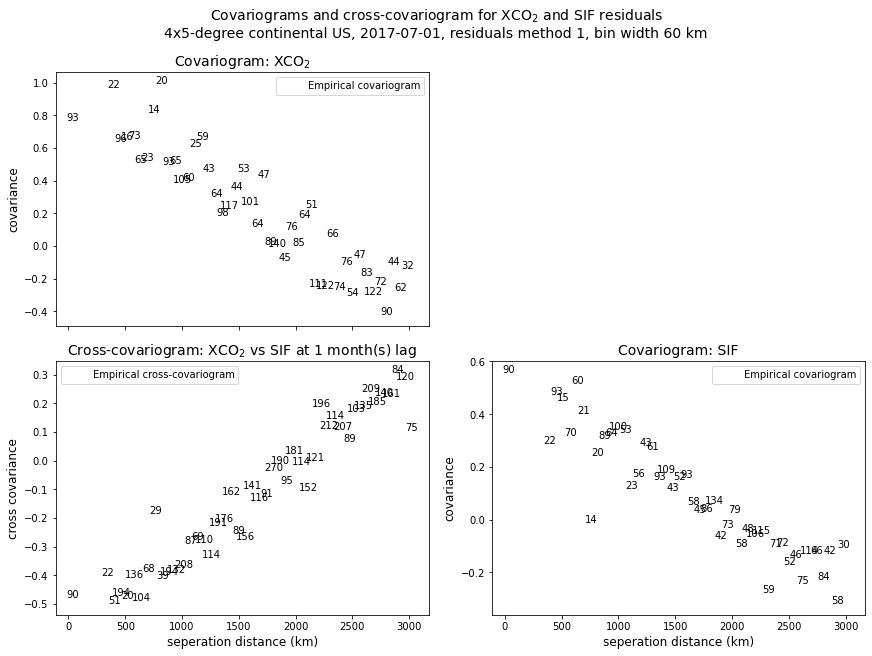

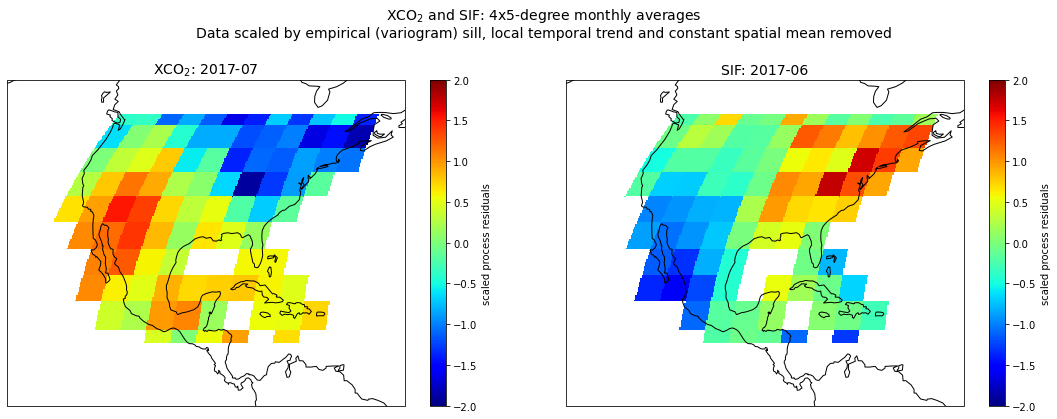

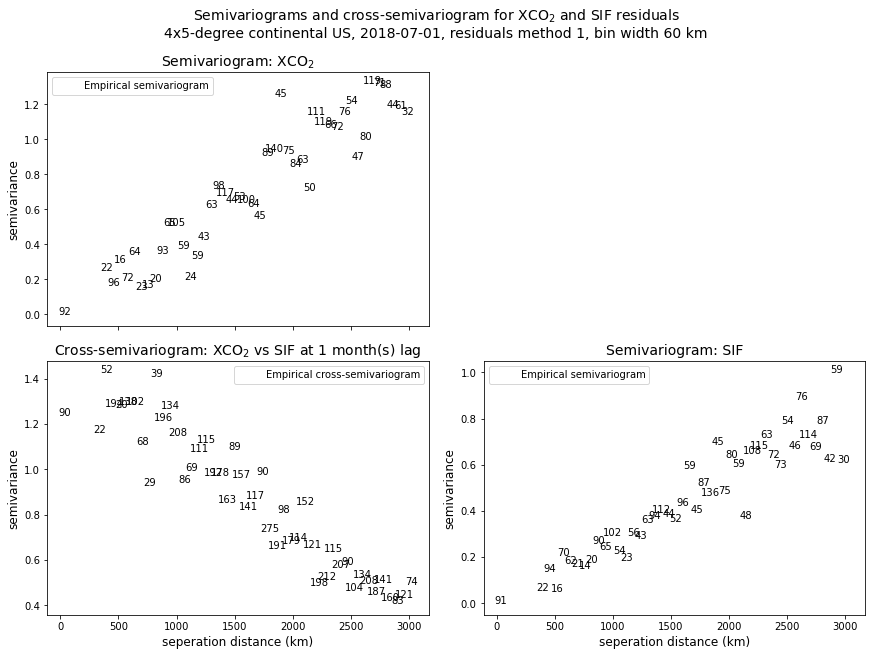

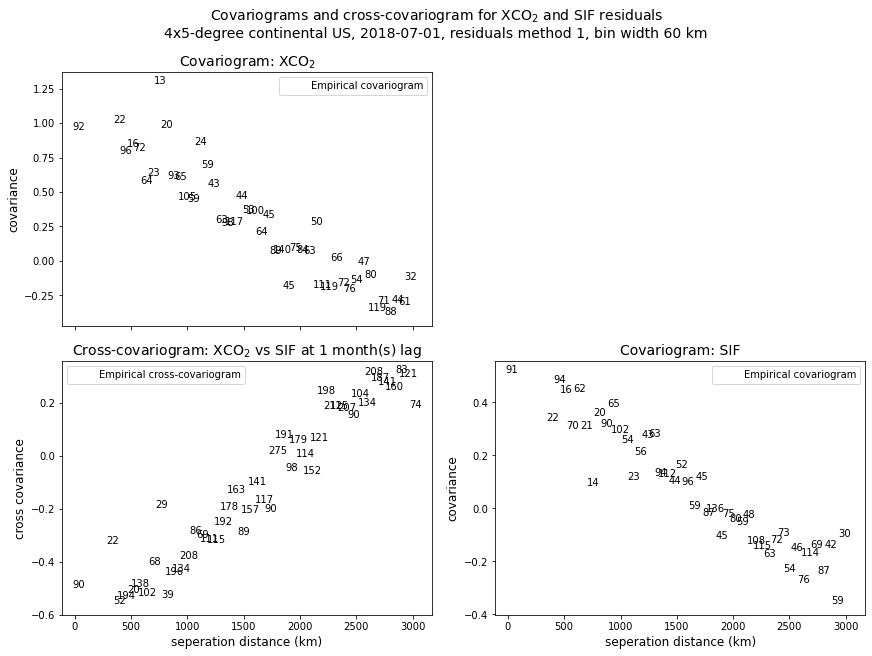

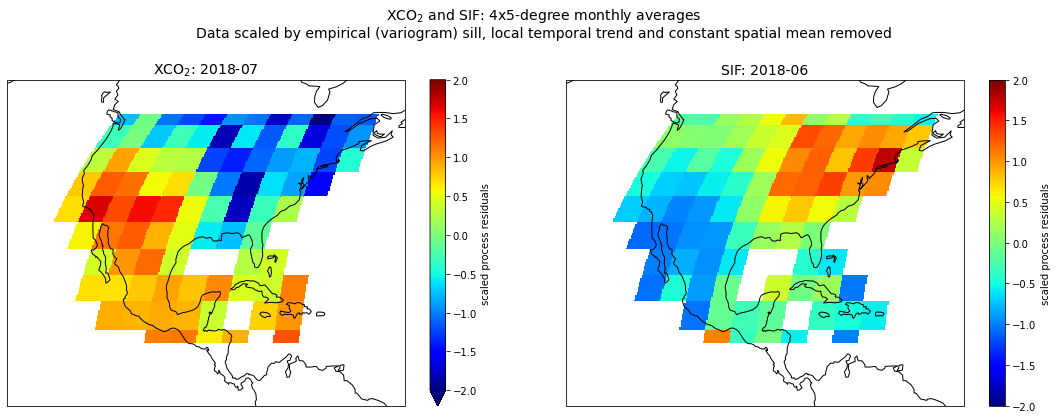

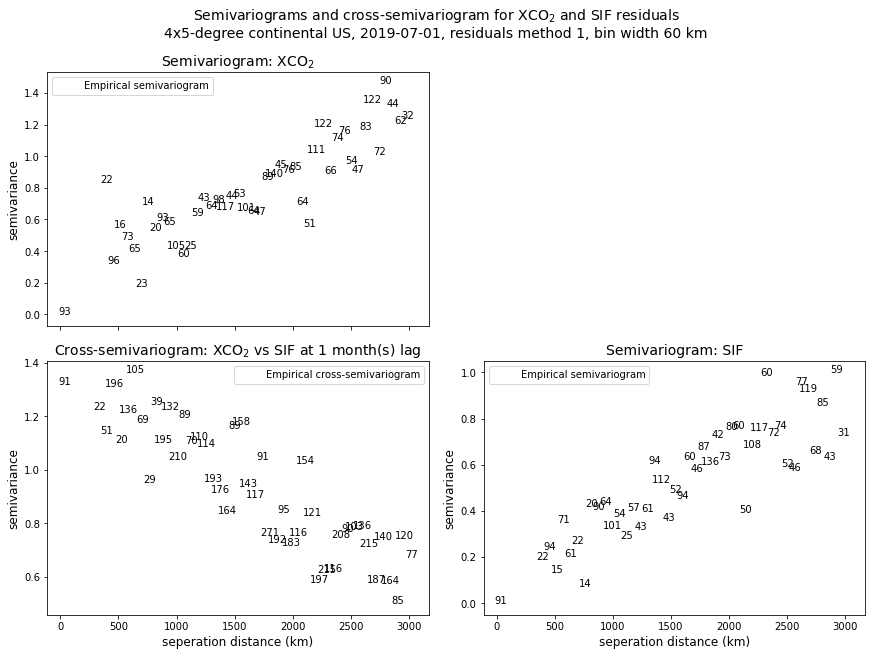

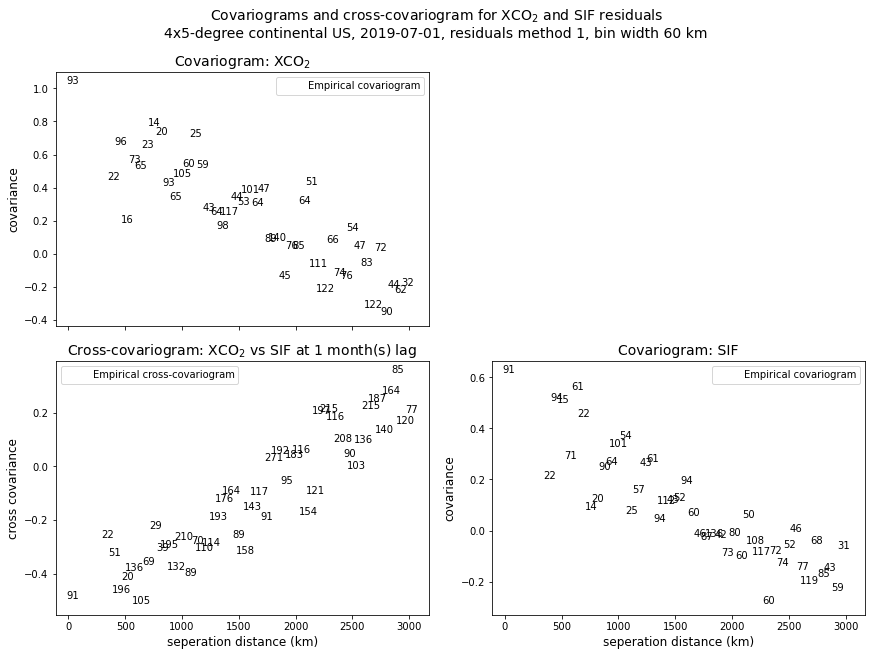

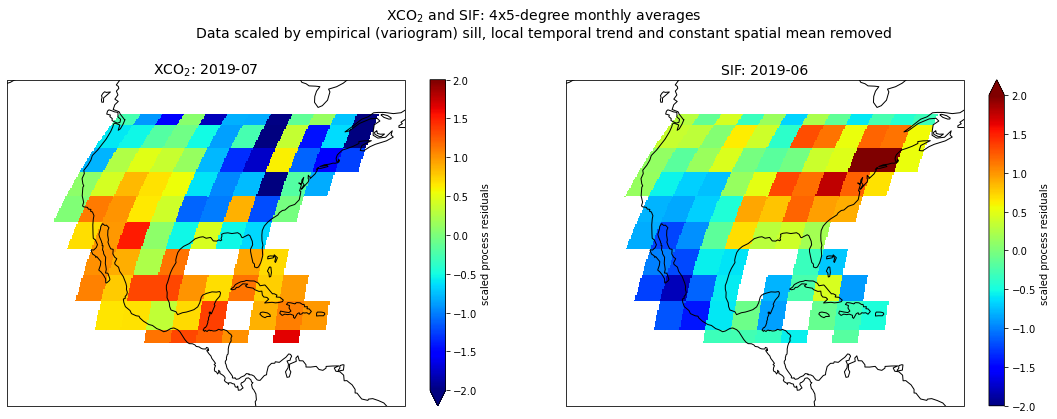

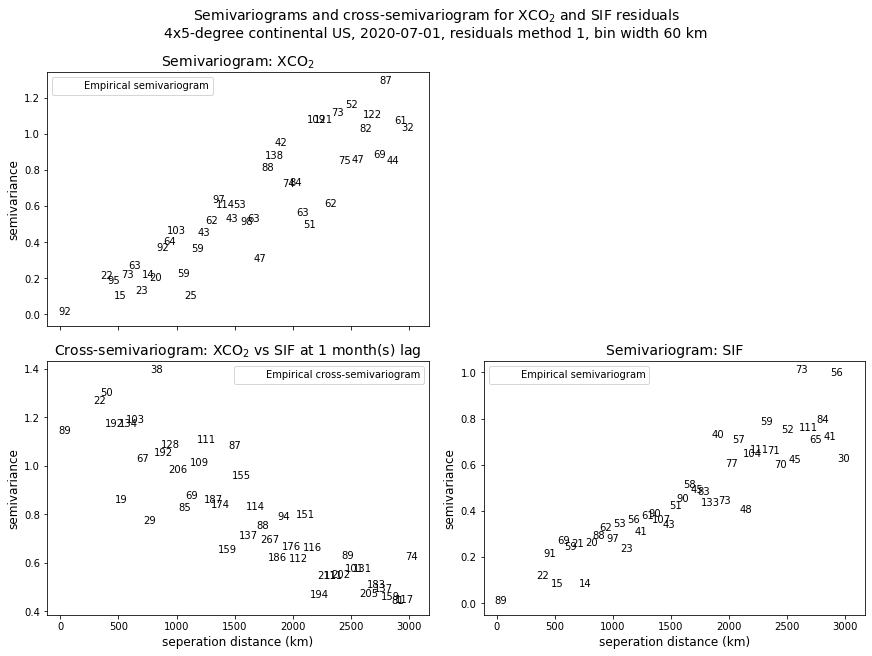

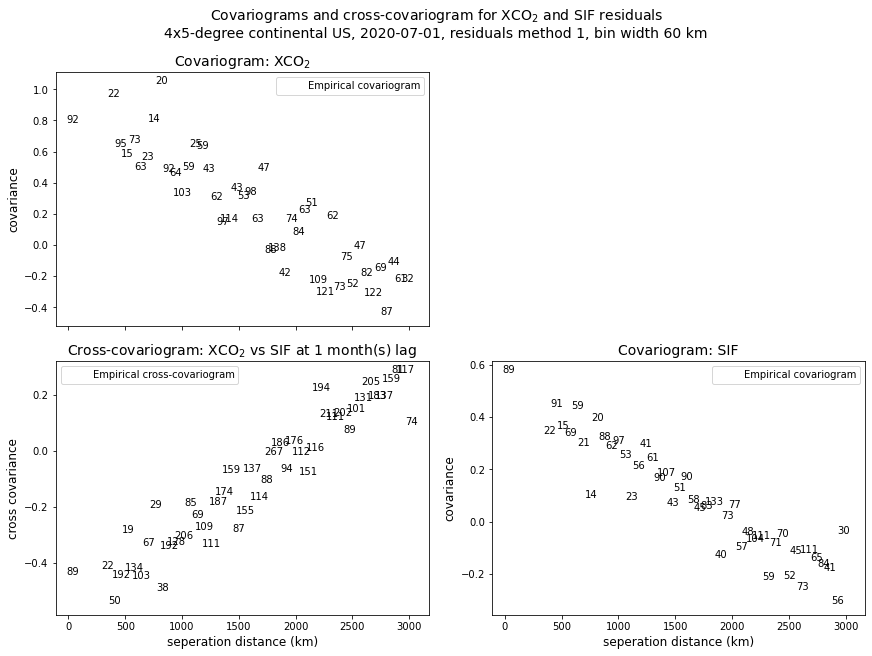

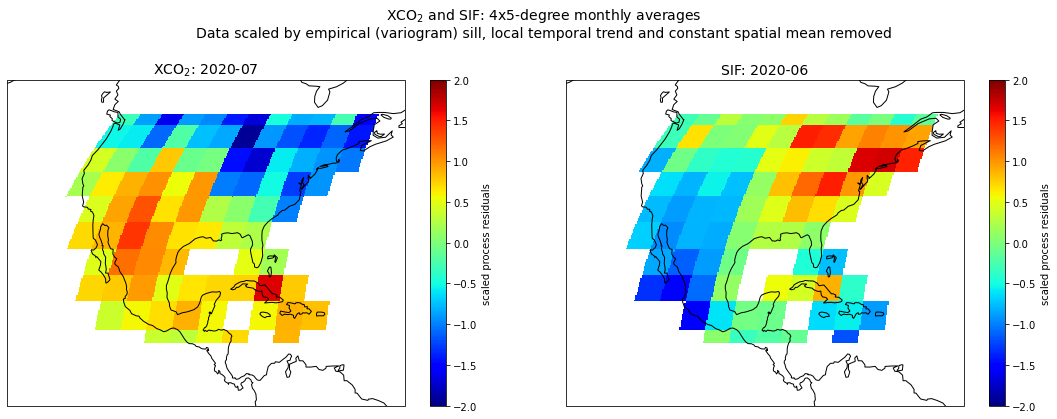

In [19]:
[method_1(timestamp) for timestamp in timestamps]